In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from lib import sauvola
from functools import reduce
from enum import Enum
import os
import utils

In [2]:
model_folders = [
#     'results/model_summary/vggnet/14-6_30-3-2022-32_6_8/',
     'results/model_summary/vggnet/17-27_29-3-2022-24_6_8/',
#     'results/model_summary/resnet/14-48_30-3-2022-32_6_8/',
#     'results/model_summary/resnet/18-20_29-3-2022-24_6_8/',
#     'results/model_summary/inceptionnet/17-25_30-3-2022-32_6_8/',
#     'results/model_summary/inceptionnet/22-29_29-3-2022-24_6_8/',
#     'results/model_summary/densenet/13-14_30-3-2022-32_6_8/',
    'results/model_summary/densenet/15-3_29-3-2022-24_6_8/',
#     'results/model_summary/inceptionresnet/15-52_30-3-2022-32_6_8/',
#     'results/model_summary/inceptionresnet/20-54_29-3-2022-24_6_8/',
#     'results/model_summary/efficientnet/16-33_30-3-2022-32_6_8/',
#     'results/model_summary/efficientnet/21-42_29-3-2022-24_6_8/'
]

In [3]:
mal = np.load('data/mal_chars_126.npy')

In [4]:
def plot_image(img):
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()
def rearrange(cnt):
    b_rect = []
    for c in cnt:
        rect = cv2.boundingRect(c)
        if rect[2] <= 18 or rect[3] <= 18:
            continue
        b_rect.append(rect)
    if b_rect == []:
        return []
    p = b_rect[0][1]+b_rect[0][3]
    #print('length of brect:',len(b_rect))
    s_rect = []
    i = 0
    length = len(b_rect)
    while i < length:
        p = b_rect[i][1]+b_rect[i][3]
#         print("i: "+str(i)+" p: "+ str(p))
        elem_on_line = []  # elements on a line
        outer = True
        while i < length and p > b_rect[i][1]:
#             print("brect-y: "+str(b_rect[i][1]))
            elem_on_line.append(b_rect[i])
            i += 1
            outer = False

        if outer:
            print("brect: "+str(b_rect[i]))
            i += 1

        elem_on_line = sorted(elem_on_line) 
#         print(elem_on_line)
        # ,key=lambda x:x[0]
        # print(elem_on_line,i)
        s_rect.extend(elem_on_line)
    return s_rect
def splMean(img, thresh):
    sum = 0
    nt = 0
    for row in img:
        for elem in row:
            if elem > thresh:
                sum += elem
            else:
                nt += 1
    if sum != 0:
        avg = sum/(img.size-nt)
    else:
        avg = 0
    # print(avg)
    return avg

def predict_word_old(p_word):
    pred = ''
    for i in p_word:
        ch = mal[i]
        lis = ch.split(' ')
        char_list = [chr(int(i)) for i in lis] 
        pred += ''.join(char_list)
    return pred
def predict_word(p_word):
    if len(p_word) == 1: 
        return predict_word_old(p_word)
    pred = ''
    char_stack = []
    for i in p_word:
        ch = mal[i]
        lis = ch.split(' ')
        char_list = [chr(int(i)) for i in lis]
       # print(char_list)

        char_list_int = [int(i) for i in lis]
        #print(char_list_int)
        if char_list_int == [3399]:  # 'േ'
            char_stack.append(chr(3399))
        elif char_list_int == [3398]:  # 'െ'
            char_stack.append(chr(3398))
        elif char_list_int == [3405, 3376]:# '്ര'
            char_stack.append(chr(3405)+chr(3376))
        else:
            char = ''.join(list(map(chr, char_list_int)))
            if len(char_stack) == 1:
                if char_stack[0] == chr(3405)+chr(3376):
                    pred += char
                    pred += chr(3405)+chr(3376)
                    char_stack.clear()
                else:
                    char_stack.append(char)
            elif len(char_stack) == 2:
                if char_list_int == [3390]:  # 'ാ'
                    if char_stack[0] == chr(3399):  # ോ
                        pred += char_stack[1]
                        pred += chr(3403)
                        char_stack.clear()
                    elif char_stack[0] == chr(3398):  # ൊ
                        pred += char_stack[1]
                        pred += chr(3402)
                        char_stack.clear()
                elif char_list_int == [3415]: #ൌ
                    pred += char_stack[1]
                    pred += chr(3404)
                    char_stack.clear()

                elif char_stack[0] == chr(3398) and char_stack[1] == chr(3398):  # െ ൈ
                    pred += char
                    pred += chr(3400)
                    char_stack.clear()
                else:
                    if char_stack[0] == chr(3399):  # 'േ'
                        pred += char_stack[1]
                        pred += chr(3399)
                        char_stack.clear()
                    elif char_stack[0] == chr(3398):  # 'െ'
                        pred += char_stack[1]
                        pred += chr(3398)
                        char_stack.clear()
            else:
                pred += char

    if char_stack:
        while len(char_stack) != 0:
            pred+= char_stack.pop()
    return pred

def plot_contour(img,contours,border_size=2):
    cont_img = img.copy()
    for c in contours:
            c_temp = cv2.boundingRect(c)
            x,y,w,h = c_temp
            cv2.rectangle(cont_img, (x, y), (x + w, y + h), (0,0, 0), border_size)
    plot_image(cont_img)

def averageHeightOfWords(words):
    avg = [i.shape[0] for i in words]
    avg_height = reduce(lambda a,b: a+b,avg) / len(avg)
    return avg_height
    

In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

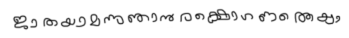

In [14]:
IN_WORDS = False
img_loc = 'data/binarized_test_data/cropped/devimahathmyam.png'
inp_img = cv2.imread(img_loc, cv2.IMREAD_GRAYSCALE)
plot_image(inp_img)

In [15]:
RESULT_PATH = 'results/reports/'
img_name = img_loc.split('/')[-1].split('.')[0]
print(img_name)
if not os.path.exists(os.path.join(RESULT_PATH,img_name)):
    os.mkdir(os.path.join(RESULT_PATH,img_name))
IMG_RESULT_PATH = os.path.join(RESULT_PATH,img_name)
if not os.path.exists(os.path.join(IMG_RESULT_PATH,'characters')):
    os.mkdir(os.path.join(IMG_RESULT_PATH,'characters'))
CHARACTERS_PATH = os.path.join(IMG_RESULT_PATH,'characters')

devimahathmyam


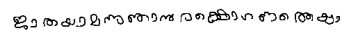

In [16]:
RESIZE = False
image = inp_img.copy()
if RESIZE:
    (row, col) = inp_img.shape
    resize_shape = (int(col * 0.7), int(row * 0.9)) # (700,1000) before 
    image = cv2.resize(inp_img,resize_shape )
else:
    image = inp_img.copy()

img = image.copy()

__, bin_img = cv2.threshold(
                img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plot_image(bin_img)

# Word Segmentation

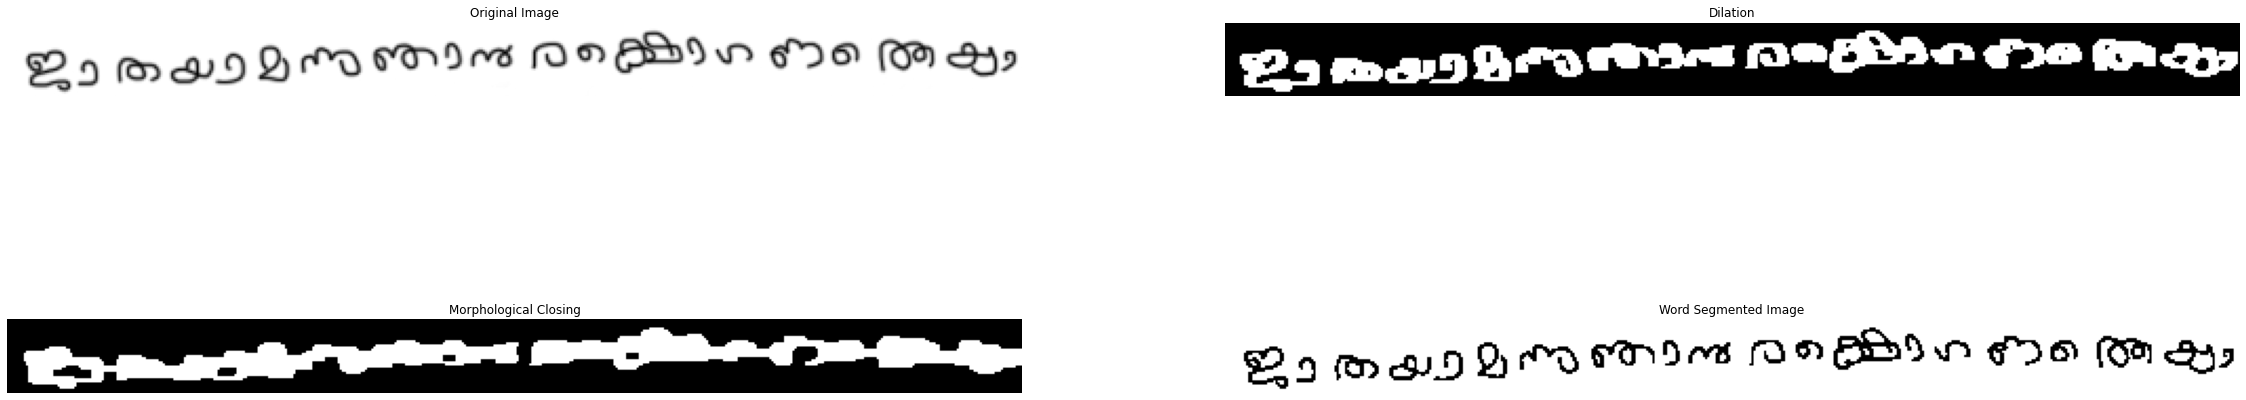

In [36]:
image = bin_img.copy()
image = cv2.bitwise_not(image)

rect=(5,1) # (16,5)
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, rect)

#Dilation (Stretching or Expansion)

dilate = cv2.dilate(image,kernel,iterations=1)

# Binarization (Otsu)
threshold = 128
_, bw = cv2.threshold(dilate, threshold, 255.0,
                              cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#Closing (DIlation + Erosion)
close_rect=(6, 3)
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, close_rect)
connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel2) 

# Finding Contour (Edges)
contours,_ = cv2.findContours( connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours.reverse()



s_rect = rearrange(contours)
words = []
i = 0
img2 = inp_img.copy()
for rect in s_rect:
    x, y, w, h = rect
    cv2.rectangle(img2, (x, y), (x+w, y+h), (0, 0, 0), 2)
    cv2.putText(img2, str(i), (x+w+10, y+h), 0, 0.3, (0, 0, 0))
    word = (inp_img[y:y+h, x:x+w])
    ret, thresh4 = cv2.threshold(word, 127, 255, cv2.THRESH_TOZERO)

    # inc is the increment for differ
    inc = 1*(255-splMean(thresh4, 90))
    #ret,thresh4 = cv2.threshold(word,127,255,cv2.THRESH_BINARY)
    thresh4 = cv2.adaptiveThreshold(word, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
    word = np.array([[min(j+inc, 255) if j > 90 else j for j in thresh4[k]]
                     for k in range(len(thresh4))], dtype=np.uint8)
    # word=thresh4
    #mplot(thresh4,word)
    words.append(word)
    i += 1

word_image = bin_img.copy()
for j, c in enumerate(contours):
    c_temp = cv2.boundingRect(c)
    if c_temp[2] <= 25 or c_temp[3] <= 25:
        continue
    x,y,w,h = c_temp
    cv2.rectangle(word_image, (x, y), (x + w, y + h), (0,0, 0), 2)
    


fig,axes = plt.subplots(2,2,figsize=(40,10))
axes[0,0].axis('off')
axes[0,0].imshow(inp_img,cmap='gray')
axes[0,0].set_title('Original Image')

axes[0,1].axis('off')
axes[0,1].imshow(dilate,cmap='gray')
axes[0,1].set_title('Dilation')

axes[1,0].axis('off')
axes[1,0].imshow(connected,cmap='gray')
axes[1,0].set_title('Morphological Closing')

axes[1,1].axis('off')
axes[1,1].imshow(word_image,cmap='gray')
axes[1,1].set_title('Word Segmented Image')

plt.savefig(IMG_RESULT_PATH+'\wordsegment.png')
plt.show()

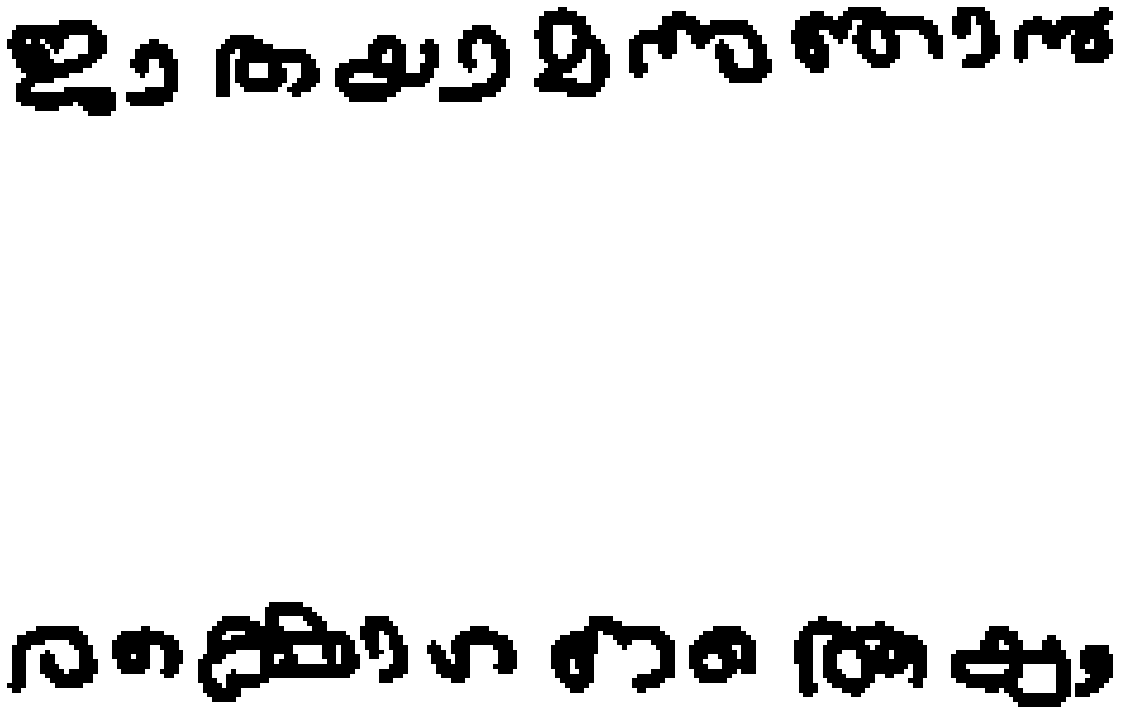

In [37]:
fig, axs = plt.subplots(len(words) if len(words)>1 else 2, 1,figsize=(20,20))
for i,word in enumerate(words):
    axs[i].imshow(word,cmap='gray')
    axs[i].axis('off')
plt.show()

In [38]:
len(words)

2

# Character Segmentation

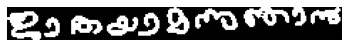

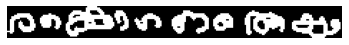

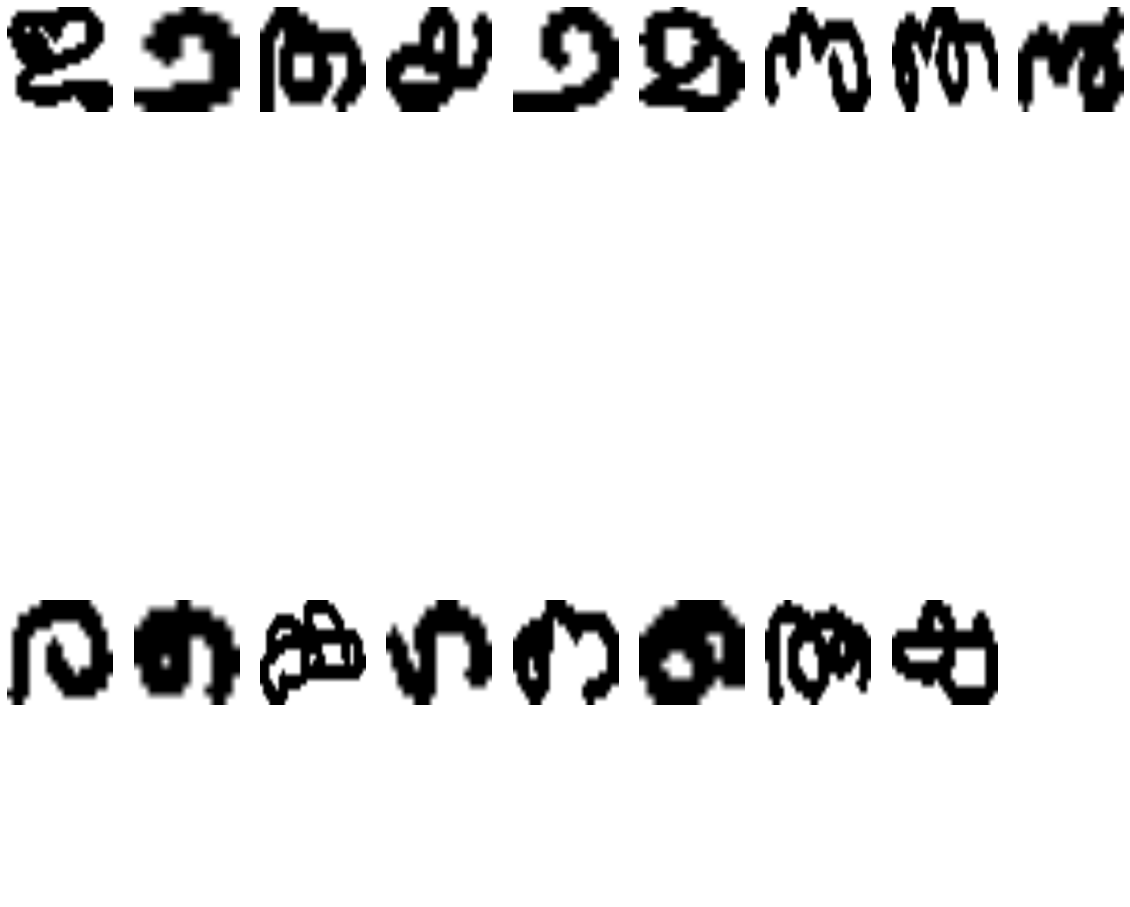

In [55]:
BORDER_SIZE = 0
CHARACTER_IMG_SIZE = (224,224)
image = inp_img.copy()
ellipse=(2,2)
rect=(2,1)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ellipse)
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, rect)

char_images = []
chars = []
count = 1
for word in words:
#     img = cv2.bitwise_not(word)
    char_img = word.copy()
    img = cv2.bitwise_not(word)
    dilate = cv2.dilate(img,kernel,iterations = 1)

    _, bw = cv2.threshold(img, threshold, 255.0,
                              cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel2)
    contours, hierarchy = cv2.findContours(
        bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    plot_image(connected)
    # reversing contour list to start processig from top
    contours.reverse()
    b_rect = []
    cnts = []
    for c in contours:
        rect = cv2.boundingRect(c)
        if rect[2] <= 10 or rect[3] <= 10:
            continue
        b_rect.append(rect)
        cnts.append(c)
    sorted_cnt = [[y,x] for y, x in sorted(zip(b_rect, cnts), key=lambda pair: pair[0])]
    seperated = []
    
    for rect,cnt in sorted_cnt:
        x,y,w,h = rect
        cv2.rectangle(char_img, (x, y), (x + w, y + h), (0,255, 0), 1)
        # removing overlap
        mask = np.zeros_like(word)
        cv2.drawContours(mask,[cnt], 0, (255,255,255), -1)
        new_image = cv2.bitwise_and(cv2.bitwise_not(word), mask)
        kernel = np.ones((3,3),np.uint8)
        #new_image = cv2.morphologyEx(new_image, cv2.MORPH_CLOSE, kernel)
        new_image = cv2.bitwise_not(new_image)
        

        char = new_image[y:y+h, x:x+w]
#         plot_image(char)
        char = cv2.copyMakeBorder(
                char, BORDER_SIZE,BORDER_SIZE,BORDER_SIZE,BORDER_SIZE, cv2.BORDER_CONSTANT, value=[255, 255, 255])
       # Changes made for 224 x 224 images
        #char = cv2.resize(char, (86, 86))
        char = cv2.cvtColor(char, cv2.COLOR_GRAY2RGB)
        char = cv2.resize(char, CHARACTER_IMG_SIZE)
        cv2.imwrite(os.path.join(CHARACTERS_PATH,f'c_{count}.jpg'),char)
        count = count + 1 
        seperated.append(char)
    chars.append(seperated)
    char_images.append(char_img)

rows = len(chars)
lengths = []
for char in chars:
    lengths.append(len(char))
cols = max(lengths)

fig,axes =plt.subplots(rows,cols,figsize=(20,20))
if axes.ndim > 1:
    for i, word in enumerate(chars):
        for j in range(cols):
            axes[i,j].axis('off')
        for j,char in enumerate(word):
            axes[i,j].imshow(char,cmap='gray')
else:
    for i,word in enumerate(chars):
        for j,char in enumerate(word):
            axes[i].imshow(char,cmap='gray')
            axes[i].axis('off')

plt.savefig(IMG_RESULT_PATH+'\characters_plt.png')
plt.show()  

# Recognition

In [56]:
models_data = []

for model_folder in model_folders:
    name_arr = model_folder.split('/')
    if name_arr[-1] == '':
        name_arr.pop()
    model_name = name_arr[-2] + '/' + name_arr[-1]
    print(model_name)
    model_datestamp = name_arr[-1]
    model = load_model(model_folder+'model_finetuned')
    output_arr = []

    for i, word in enumerate(chars):
        if word == []:
            continue
        word = np.array(word)
    #             word = word.astype('float32') / 255.
    #             word = word.reshape(-1,224,224,3)
        pred = np.argmax(model.predict([word]), axis=-1)
        pred_word = predict_word(pred)
        if IN_WORDS:
            print(pred_word, end=" ")
        output_arr.append(pred_word)
        if not IN_WORDS:
            output = ''.join(map(str, output_arr))
            #print(output)
        else:
            output = output_arr
    print(output)
    model_data = {'name': model_name,
                      'date': model_datestamp, 'output': output}
    models_data.append(model_data)

vggnet/14-6_30-3-2022-32_6_8
ംംഖംംംമ്പന്ധധംംയഗശംണഋ
vggnet/17-27_29-3-2022-24_6_8
ംംശംംമന്ഥശമ്പംംക്ഷശശംശഴ
resnet/14-48_30-3-2022-32_6_8
മായൊമനശഗ്നരറമ്മഗരംരക
resnet/18-20_29-3-2022-24_6_8
ഉംംൊംനതഗ്നരംകഗരംതക
inceptionnet/17-25_30-3-2022-32_6_8
മീതകംംനഞൗരനകനനകതക
inceptionnet/22-29_29-3-2022-24_6_8
മാതങ്കംമതഞൗരീങ്കഗ്നീഠതക
densenet/13-14_30-3-2022-32_6_8
ഭാലധറമഗ്നണഗ്നാലകററധൈ
densenet/15-3_29-3-2022-24_6_8
ഭാകറെഗ്നനഗ്നറർകറനകൈ
inceptionresnet/15-52_30-3-2022-32_6_8
മമകകരമകതന്നരരക്ഷഗരകെ
inceptionresnet/20-54_29-3-2022-24_6_8
മമക്കൊകകതനരകക്ഷഗരകെ
efficientnet/16-33_30-3-2022-32_6_8
ജൗകയ്യറക്കൈന്ധരെറകകതക
efficientnet/21-42_29-3-2022-24_6_8
മൗഖകറഎെന്നരെറകകതക


In [ ]:
del model 

## Saving output

In [ ]:
from docx import Document
from docx.shared import Inches

document = Document()

document.add_heading('Character Recognition', 0)
document.add_heading('Input Image', 2)
document.add_picture(img_loc, width=Inches(3))
document.add_heading('Outputs', 2)
for data in models_data:
    document.add_heading(data['name'].upper(), 3)
    document.add_heading(f"Timestamp: {data['date']}", 4)
    document.add_heading('Output', 5)
    if model_types:
        output_data = data['output']
        for output in output_data:
            document.add_heading(f"Type: {output['type']}", 5)
            p = document.add_paragraph('')
            if IN_WORDS:
                for words in output['output']:
                    p.add_run(words).bold = True
                    p.add_run(' ')
            else:
                p.add_run(output['output']).bold = True
                p.add_run(' ')
    else:
        p = document.add_paragraph('')
        if IN_WORDS:
            for words in data['output']:
                p.add_run(words).bold = True
                p.add_run(' ')
        else:
            p.add_run(data['output']).bold = True
            p.add_run(' ')


file_name = f"output_{img_name}.docx"
document.save(os.path.join(RESULT_PATH, img_name, file_name))
osCommandString = f"start {os.path.join(RESULT_PATH,img_name,file_name)}"
os.system(osCommandString)

In [ ]:
chr(3350)+chr(3405)+chr(3381)

In [ ]:
chr(3350)+chr(3395)

In [ ]:
chr(3350)+chr(3405)+chr(3375)

In [ ]:
BORDER_SIZE = 0
CHARACTER_IMG_SIZE = (224, 224)
image = bin_img.copy()
ellipse = (3, 3)
rect = (2, 1)
threshold = 128
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ellipse)
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, rect)

char_images = []
chars = []
count = 1

#     img = cv2.bitwise_not(word)
char_img = image.copy()
img = cv2.bitwise_not(image)
grad = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)
#     word_copy = cv2.bitwise_not(word)
_, bw = cv2.threshold(grad, threshold, 255.0,
                      cv2.THRESH_BINARY | cv2.THRESH_OTSU)

connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel2)
contours, hierarchy = cv2.findContours(
    connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
plot_image(connected)
# reversing contour list to start processig from top
contours.reverse()
b_rect = []
cnts = []
for c in contours:
    rect = cv2.boundingRect(c)
    if rect[2] <= 10 or rect[3] <= 10:
        continue
    b_rect.append(rect)
    cnts.append(c)
    sorted_cnt = [[y, x] for y, x in sorted(
        zip(b_rect, cnts), key=lambda pair: pair[0])]
    seperated = []

    for rect, cnt in sorted_cnt:
        x, y, w, h = rect
        cv2.rectangle(char_img, (x, y), (x + w, y + h), (0, 255, 0), 1)
        # removing overlap
        mask = np.zeros_like(image)
        cv2.drawContours(mask, [cnt], 0, (255, 255, 255), -1)
        new_image = cv2.bitwise_and(cv2.bitwise_not(image), mask)
        kernel = np.ones((3, 3), np.uint8)
        new_image = cv2.morphologyEx(new_image, cv2.MORPH_CLOSE, kernel)
        new_image = cv2.bitwise_not(new_image)

        char = new_image[y:y+h, x:x+w]
#         plot_image(char)
        char = cv2.copyMakeBorder(
            char, BORDER_SIZE, BORDER_SIZE, BORDER_SIZE, BORDER_SIZE, cv2.BORDER_CONSTANT, value=[255, 255, 255])
       # Changes made for 224 x 224 images
        # char = cv2.resize(char, (86, 86))
        char = cv2.cvtColor(char, cv2.COLOR_GRAY2RGB)
        char = cv2.resize(char, CHARACTER_IMG_SIZE)
        cv2.imwrite(os.path.join(CHARACTERS_PATH, f'c_{count}.jpg'), char)
        count = count + 1
        chars.append(char)




In [ ]:
rows = len(chars_normal)
plt.figure(figsize=(20, 20))

for i in range(rows):
    plt.subplot(int(rows/8), 10, i+1)
    plt.imshow(chars_normal[i], cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
#plt.savefig(IMG_RESULT_PATH+'\characters_plt.png')
plt.show()

In [ ]:
len(chars)

In [ ]:
import utils

In [ ]:
chars_normal = utils.character_segmentation(img_loc)

In [ ]:
len(chars_normal)